## Data Cleaning

### Remove Outliers

In [2]:
## Imports ##
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree
from sklearn import neighbors
from sklearn import preprocessing 
import pandas as pd
from textblob import TextBlob
import sklearn.preprocessing as pp
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
import nltk
import statistics as stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster as clust
import seaborn as sns
from sklearn import neighbors
import sklearn.decomposition as decomp
import time
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score


target_name = 'price'
path = '../data/cleaned_data/'
fname = 'listings_complex.csv'

## Clean Extreme Outlier Prices ##
data = pd.read_csv(open(path+ fname))
median = data[target_name].quantile(.5)
upper_quartile = data[target_name].quantile(.75)
lower_quartile = data[target_name].quantile(.25)
iqr = upper_quartile - lower_quartile
outlier_upper = data[data[target_name]<=upper_quartile+3*iqr][target_name].max()
outlier_under = data[data[target_name]>=max(lower_quartile-3*iqr,0)][target_name].min()
print(f'Upper Outlier Bound: {outlier_upper}\nLower Outlier Bound: {outlier_under}')
blen = len(data)
data = data[(data['price']<outlier_upper) & (data['price']>outlier_under)]
alen = len(data)
print(f'Removing Extreme Outliers cost us {round((blen-alen)/blen*100,2)}% of the data')

Upper Outlier Bound: 403.0
Lower Outlier Bound: 0.0
Removing Extreme Outliers cost us 3.25% of the data


### Deal With Null Values


In [5]:
## Initial Overview of Columns ##
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_searched', 'last_scraped',
       'name', 'description', 'neighborhood_overview', 'picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bathroom_type', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'has_availability

In [3]:
## These variables are not useful in answering how much a first-time user should list their property at given they will not have this information readily available ##
data = data.drop(labels=['last_searched', 
                  'review_scores_value',
                  'review_scores_location', 
                  'review_scores_checkin', 
                  'review_scores_communication', 
                  'review_scores_accuracy', 
                  'review_scores_cleanliness', 
                  'review_scores_rating', 
                  'reviews_per_month',
                  'last_review',
                  'first_review',
                  'id',
                  'listing_url',
                  'scrape_id',
                  'last_scraped',
                  'picture_url',
                  'host_id',
                  'host_url',
                  'host_name',
                  'host_since',
                  'host_location',
                  'host_thumbnail_url',
                  'host_picture_url',
                  'host_listings_count',
                  'host_total_listings_count',
                  'has_availability', 
                  'availability_30',
                  'availability_60',
                  'availability_90',
                  'availability_365',
                  'calendar_last_scraped',
                  'number_of_reviews', 
                  'number_of_reviews_ltm',
                  'number_of_reviews_l30d',
                  'host_verifications',
                  'calculated_host_listings_count',
                  'calculated_host_listings_count_entire_homes',
                  'calculated_host_listings_count_private_rooms',
                  'calculated_host_listings_count_shared_rooms'], axis=1)

In [4]:
## region_name, region_parent_name, and region_parent_parent_name are redundant versions of region_id, region_parent_id, and region_parent_parent_id ##
## property_type is largely redundant information on room_type ##
data = data.drop(labels=['region_name', 
                         'property_type',
                         'region_parent_name', 
                         'region_parent_parent_name'],axis=1)

In [5]:
## Find the columns where number of nulls exceeds 10% of the data ##
df = (data.isna().sum().sort_values(ascending=False).head(20)/len(data))
df = df[df > .10]
df

license                  1.000000
bathrooms                1.000000
calendar_updated         1.000000
requires_license         1.000000
host_neighbourhood       0.531077
host_about               0.529419
neighborhood_overview    0.394093
neighbourhood            0.394093
host_response_time       0.330753
host_response_rate       0.330753
host_acceptance_rate     0.292766
dtype: float64

In [6]:
## These Variables have very high percentage of null values and are unlikely to be useful in our analysis ##
data = data.drop(labels=['bathrooms',
                  'license', 
                  'calendar_updated', 
                  'requires_license', 
                  'host_neighbourhood', 
                  'host_about', 
                  'neighbourhood'], axis=1)

In [7]:
numeric_columns = set(data.select_dtypes(include=np.number).columns.tolist()) - set([target_name])
categorical_columns = set(data.columns.tolist()) - numeric_columns - set([target_name])
numeric_columns = list(numeric_columns)
categorical_columns = list(categorical_columns)
print('\033[1m'+"Numeric Columns"+'\033[0m')
for el in numeric_columns:
    print(el)
print('\n')
print('\033[1m'+"Categorical Columns"+'\033[0m')
for el in categorical_columns:
    print(el)

Numeric Columns
bathrooms_text
latitude
minimum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
host_acceptance_rate
accommodates
longitude
minimum_minimum_nights
minimum_maximum_nights
region_id
maximum_nights
beds
bedrooms
maximum_minimum_nights
host_response_rate
region_parent_id
maximum_nights_avg_ntm


Categorical Columns
host_identity_verified
instant_bookable
room_type
bathroom_type
neighborhood_overview
region_parent_parent_id
name
host_has_profile_pic
description
host_response_time
amenities
host_is_superhost


## Feature Engineering 

### Numerical Variables

In [8]:
## Look into Null Counts ## 
data[numeric_columns].isna().sum().sort_values(ascending=False)

host_response_rate        8376
host_acceptance_rate      7414
bedrooms                   760
beds                       142
bathrooms_text              52
region_id                    0
region_parent_id             0
maximum_minimum_nights       0
maximum_nights               0
minimum_maximum_nights       0
latitude                     0
minimum_minimum_nights       0
longitude                    0
accommodates                 0
minimum_nights_avg_ntm       0
maximum_maximum_nights       0
minimum_nights               0
maximum_nights_avg_ntm       0
dtype: int64

In [9]:
## Get Rid of Nulls Rows For Columns with Low Null Counts ##
data = data.drop(labels=['beds','bathrooms_text'],axis=1)
numeric_columns = list(set(numeric_columns) - set(['beds','bathrooms_text']))

## MVI for Other Columns with Nulls ##
for element in ['host_response_rate','host_acceptance_rate', 'bedrooms']:
    mean = data[data[element].notnull()][element].mean()
    data[element] = data[element].apply(lambda x: mean if np.isnan(x) else x)

### Categorical Variables

#### Numerize region_parent_parent_id ####

In [10]:
data.region_parent_parent_id.unique()

array(['IE061', 'IE053', 'IE042', 'IE063', 'IE062', 'IE051', 'IE041',
       'IE052'], dtype=object)

In [11]:
data.region_parent_parent_id = data.region_parent_parent_id.apply(lambda x: x.replace('IE0','')).astype(int)
data.region_parent_parent_id

0        61
1        61
2        61
3        61
4        61
         ..
26171    42
26172    41
26173    42
26174    53
26175    51
Name: region_parent_parent_id, Length: 25324, dtype: int64

#### Numerize Plain Text Columns ####

In [12]:
## Check Number of Null Columns for each plain text column##
plain_text_cols = ['name','description','neighborhood_overview']
for col in plain_text_cols:
    print(f'The number of rows in "{col}" column with null values: {data[col].isna().sum()}')

The number of rows in "name" column with null values: 2
The number of rows in "description" column with null values: 594
The number of rows in "neighborhood_overview" column with null values: 9980


In [13]:
## Drop the null columns if small number of rows ##
data.dropna(subset = ['name'], inplace=True)

name: (Max: 1.0, Min: -1.0)
description: (Max: 1.0, Min: -0.8)
neighborhood_overview: (Max: 1.0, Min: -0.8)


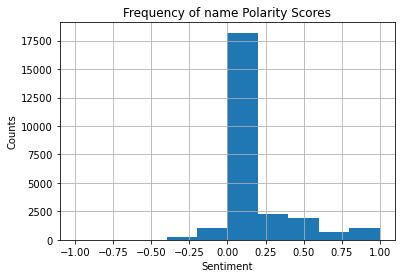

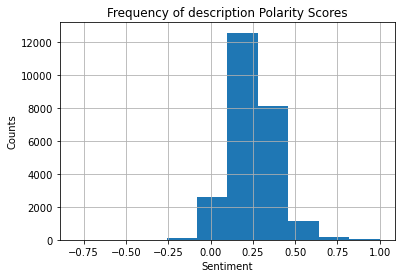

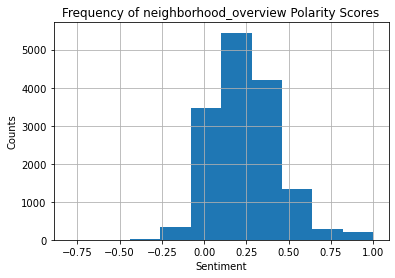

In [14]:
## Check Distributions of Sentiments of Each Plain Text Column ##
for col in plain_text_cols:
    plt.figure()
    data[col] = data[col].apply(lambda x: TextBlob(x).sentiment.polarity if type(x) is str else np.nan)
    data[data[col] != np.nan][col].hist()
    plt.title("Frequency of " + col + " Polarity Scores")
    plt.xlabel("Sentiment")
    plt.ylabel("Counts")
    pd.DataFrame({'count' : data.groupby(col).size()}).reset_index().sort_values(by='count',ascending=False).head(10)
    print(f'{col}: (Max: {data[data[col] != np.nan][col].max()}, Min: {data[data[col] != np.nan][col].min()})')

In [15]:
## Drop Categories w/ too many 'N/A' values into Bins
description_mean = data[data['description'].notnull()]['description'].mean()
neighborhood_overview_mean = data[data['neighborhood_overview'] != np.nan]['neighborhood_overview'].mean()
data.description = data.description.apply(lambda x: description_mean if np.isnan(x) else x)
data.neighborhood_overview = data.neighborhood_overview.apply(lambda x: neighborhood_overview_mean if np.isnan(x) else x)


#### Numerize Other Categorical Columns ####

In [16]:
remaining_cat_cols = set(categorical_columns) - set(['neighborhood_overview', 'description', 'name', 'region_parent_parent_id'])
remaining_cat_cols = list(remaining_cat_cols)
lst = []
for entry in remaining_cat_cols:
    lst.append([entry,len(data[entry].unique())])
df = pd.DataFrame(data=lst, columns=['column name', 'number of unique values']).sort_values(by='number of unique values',ascending=False)
df

,column name,number of unique values
6,amenities,23695
5,host_response_time,5
2,room_type,4
0,host_identity_verified,3
3,bathroom_type,3
4,host_has_profile_pic,3
7,host_is_superhost,3
1,instant_bookable,2


In [17]:
non_one_hot_encodable_cat_cols = ['amenities']
one_hot_encodable_cat_cols = set(remaining_cat_cols) - set(non_one_hot_encodable_cat_cols)
one_hot_encodable_cat_cols = list(one_hot_encodable_cat_cols)
df = (data[one_hot_encodable_cat_cols].isna().sum().sort_values(ascending=False)/len(data)).head(20)
df

host_response_time        0.330740
bathroom_type             0.087710
host_identity_verified    0.002409
host_has_profile_pic      0.002409
host_is_superhost         0.002409
instant_bookable          0.000000
room_type                 0.000000
dtype: float64

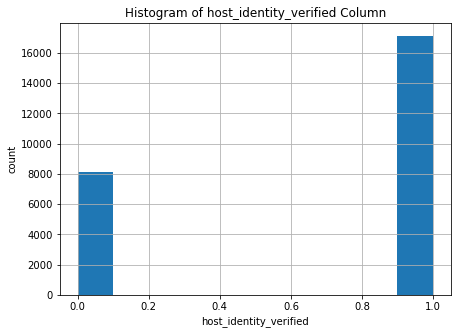

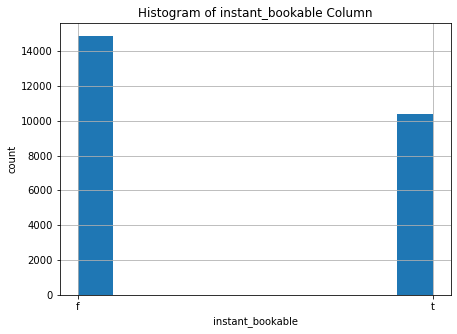

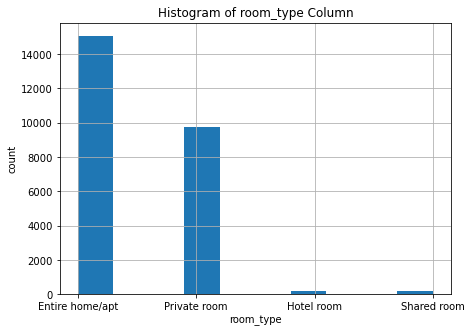

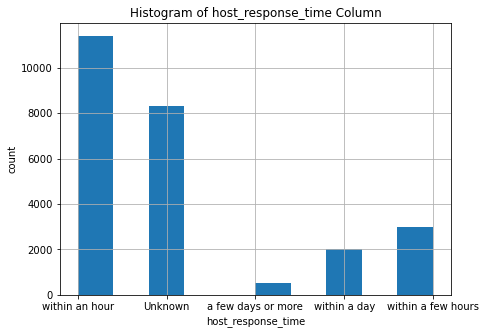

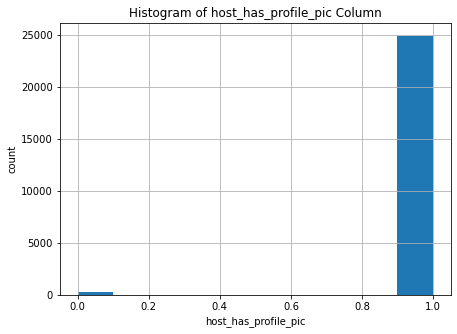

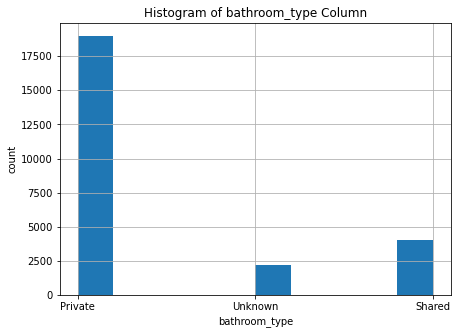

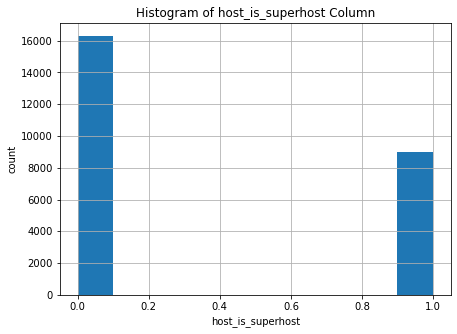

In [18]:
## Drop null rows of categorical columns with low number of nulls ## 
data = data.dropna(subset=['room_type', 'instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified'])
data[["host_is_superhost", "host_has_profile_pic", "host_identity_verified"]] *= 1
## Convert Booleans to Strings ## 

# Create Categorical Bins for data that has high number of nulls ##
data['bathroom_type'] = data['bathroom_type'].apply(lambda x: 'Unknown' if type(x) is float else x)
data['host_response_time'] = data['host_response_time'].apply(lambda x: 'Unknown' if type(x) is float else x)
for entry in one_hot_encodable_cat_cols:
    plt.figure(figsize=(7,5))
    plt.title(f'Histogram of {entry} Column')
    plt.xlabel(entry)
    plt.ylabel('count')
    data[entry].hist();

In [19]:
## Drop Highly Skewed One-Hot Encodings ##
transformed_df = pd.get_dummies(data[one_hot_encodable_cat_cols])
data = data.drop(labels=one_hot_encodable_cat_cols,axis=1)

data[transformed_df.columns] = transformed_df
data.columns

Index(['name', 'description', 'neighborhood_overview', 'host_response_rate',
       'host_acceptance_rate', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'region_id',
       'region_parent_id', 'region_parent_parent_id',
       'host_identity_verified_0', 'host_identity_verified_1',
       'instant_bookable_f', 'instant_bookable_t', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'host_response_time_Unknown',
       'host_response_time_a few days or more',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_has_profile_pic_0',
       'host_has_profile_pic_1', 'bathroom_type_Private',
  

In [20]:
# The Remaining Non One Hot Encodable Columns ##
non_one_hot_encodable_cat_cols

['amenities']

In [21]:
unique_amenities_strings = set([])
for entry in data.amenities:
    string = entry
    string = string.replace('[','')
    string = string.replace(']','')
    string = string.replace('"','')
    string_splits = string.split(',')
    unique_amenities_strings = unique_amenities_strings.union(set(string_splits))
len(unique_amenities_strings)

1648

In [22]:
n_centrums = [10, 50, 100, 200]

def numerize_amenities(data, n, unique_amenities_strings):
    print(f'Centrums: {n}')
    data_copy = data.copy()
    corpus = list(unique_amenities_strings)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    kmeans = clust.KMeans(n_clusters=n).fit(X)
    
    map_amenities_clusters = {}
    
    ## Function for transforming amenities from a lst of strings to a list of numbers (which represent clusters)  ## 
    def strings_to_clusters(original_amenities_string):
        clusters = []
        string = original_amenities_string
        string = string.replace('[','')
        string = string.replace(']','')
        string = string.replace('"','')
        string_splits = string.split(',')
        for entry in string_splits:
            clusters.append(map_amenities_clusters[entry])
        return clusters

    ## Create map of strings in amenities to clusters ##
    for cluster in set(kmeans.labels_):
        cluster_amenities_list = [i for indx,i in enumerate(corpus) if kmeans.labels_[indx] == cluster]
        for amenity in cluster_amenities_list:
            map_amenities_clusters[amenity] = cluster
    data_copy['amenities'] = data_copy['amenities'].apply(strings_to_clusters)
    
    ## One-Hot Encode These Amenities ##
    for index in range(len(set(kmeans.labels_))):
        data_copy['contains_amenity_cluster_'+str(index)] = data_copy['amenities'].apply(lambda x: 1 if index in x else 0)
    data_copy = data_copy.drop(labels='amenities', axis=1)
    return data_copy

data_list = {}
for n in n_centrums:
    data_list[n] = numerize_amenities(data, n, unique_amenities_strings) 

Centrums: 10
Centrums: 50
Centrums: 100


/var/folders/jm/bksk53kj0zdfl9hhmmfvg7yh0000gn/T/ipykernel_19137/2407790162.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy['contains_amenity_cluster_'+str(index)] = data_copy['amenities'].apply(lambda x: 1 if index in x else 0)


Centrums: 200


/var/folders/jm/bksk53kj0zdfl9hhmmfvg7yh0000gn/T/ipykernel_19137/2407790162.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy['contains_amenity_cluster_'+str(index)] = data_copy['amenities'].apply(lambda x: 1 if index in x else 0)


### Sanity Check

In [23]:
## Check to Ensure All Categorical Variables Have Been Numerized ##
cat_var_count = {}
for entry in data_list:
    cat_var_count[entry] = len(set(data_list[entry].columns)-set(data_list[entry].select_dtypes(include=np.number).columns.tolist()))

## Ensure Every Single Entry in data array is non-null (and thus every numeric column is non-null)
null_count = {}
for entry in data_list:
    null_count[entry] = data_list[entry].isna().sum().sort_values(ascending=False).sum()
pd.concat([pd.Series(null_count), pd.Series(cat_var_count)], axis=1).reset_index().rename(columns={'index': 'n_clusters', 0: "Number of Categorical Variables", 1: "Number of Nulls"})

,n_clusters,Number of Categorical Variables,Number of Nulls
0,10,0,0
1,50,0,0
2,100,0,0
3,200,0,0


### Model Selection

In [24]:
gb = {}
rf = {}
knn = {}
for entry in data_list:
    features_names = list(set(data_list[entry].columns)-set([target_name]))
    X = data_list[entry][features_names]
    y = data_list[entry][target_name]
    X_fold, X_test, y_fold, y_test = model_selection.train_test_split(X,y,test_size=.2)
    gb[entry] = model_selection.cross_val_score(XGBRegressor(), X_fold, y_fold ,cv=5,scoring="r2").mean()
    rf[entry] = model_selection.cross_val_score(ensemble.RandomForestRegressor(), X_fold, y_fold ,cv=5,scoring="r2").mean()
    knn[entry] = model_selection.cross_val_score(neighbors.KNeighborsRegressor(), X_fold, y_fold ,cv=5,scoring="r2").mean()
    print(entry)
pd.DataFrame.from_dict({'Gradient Boosting Regressor': gb,'Random Forest Regressor': rf,'KNN Regressor': knn}, orient='index')

10
50
100
200


,10,50,100,200
Gradient Boosting Regressor,0.526703,0.526675,0.535945,0.540121
Random Forest Regressor,0.526841,0.524403,0.529302,0.531657
KNN Regressor,0.316870,0.326380,0.326602,0.336994


### Model Improvement

Number of Features in model with n_clusters=10: 51
Number of Features in model with n_clusters=50: 91
Number of Features in model with n_clusters=100: 141
Number of Features in model with n_clusters=200: 241


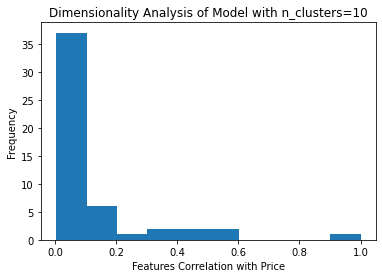

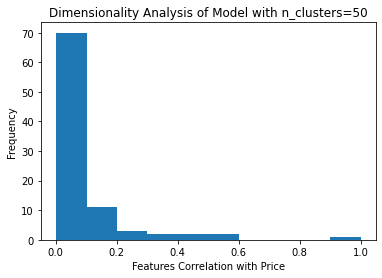

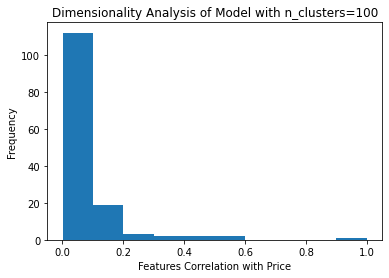

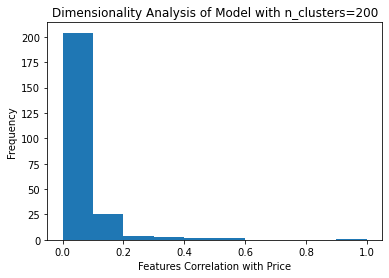

In [25]:
for entry in data_list:
    correlation = data_list[entry].corr(method='pearson').abs().reset_index()
    plt.figure()
    plt.hist(correlation['price'])
    plt.title(f'Dimensionality Analysis of Model with n_clusters={entry}')
    plt.xlabel('Features Correlation with Price')
    plt.ylabel('Frequency')
    print(f'Number of Features in model with n_clusters={entry}: {len(data_list[entry].columns)}')

In [26]:
import sklearn.preprocessing as pp

learning_rates = [.05,.075,.1,.3]
n_estimators = [100,150,200]
n_clusters_best = 10
features_names = list(set(data_list[n_clusters_best].columns)-set([target_name]))
X = data_list[n_clusters_best][features_names]
y = data_list[n_clusters_best][target_name]
X_fold, X_test, y_fold, y_test = model_selection.train_test_split(X,y,test_size=.1)
for rate in learning_rates:
    for n in n_estimators:
        print(f'(rate={rate},n={n}): {model_selection.cross_val_score(XGBRegressor(learning_rate=rate,n_estimators=n), X_fold, y_fold ,cv=10,scoring="r2").mean()}')

(rate=0.05,n=100): 0.5213486257551408
(rate=0.05,n=150): 0.5324035415859357
(rate=0.05,n=200): 0.5382082205449964
(rate=0.075,n=100): 0.5321810335613855
(rate=0.075,n=150): 0.5401657523648516
(rate=0.075,n=200): 0.5455613464608351
(rate=0.1,n=100): 0.5366982816223496
(rate=0.1,n=150): 0.5419232196227354
(rate=0.1,n=200): 0.5461288131385157
(rate=0.3,n=100): 0.5386452176208325
(rate=0.3,n=150): 0.540011324637035
(rate=0.3,n=200): 0.5395543745696121


In [27]:
xgb_reg_start = time.time()

xgb_reg = XGBRegressor(learning_rate=.1,n_estimators=100)
xgb_reg.fit(X_fold, y_fold)
training_preds_xgb_reg = xgb_reg.predict(X_fold)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_fold, training_preds_xgb_reg),4))
print("Testing MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_fold, training_preds_xgb_reg),4))
print("Testing r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 1603.9562
Testing MSE: 2107.847

Training r2: 0.654
Testing r2: 0.5367
